# Exercise 2: LQR & ILQR

In this exercise you will learn how to develop your own LQR and ILQR algorithms. For this task we need to use CasADi, a library for symbolic calculation for python. This library composes functionalities not only symbolic calculation, but also automatic differentiation, numerical integration, linear and nonlinear programming solvers. We find its various use cases in control engineering such as control for quadrotors and automotives. 

For tutiorials and usages please refer to the [CasADi documentation](https://web.casadi.org/).

In [1]:
import gymnasium
import numpy as np
import scipy.linalg
import casadi as cs
from ml_collections import config_dict
import matplotlib.pyplot as plt
from IPython.display import clear_output 

from crazyflow.control.controller import Control, Controller
from crazyflow.sim.physics import Physics

from crazyflow.sim.symbolic import symbolic
from crazyflow.constants import MASS, GRAVITY, J

Set up the environment.

In [2]:
# set config for simulation
sim_config = config_dict.ConfigDict()
sim_config.device = "cpu"
sim_config.physics = Physics.default
sim_config.control = Control.thrust
sim_config.controller = Controller.default
sim_config.control_freq = 500
sim_config.n_drones = 1
sim_config.n_worlds = 1 #20

envs = gymnasium.make_vec(
    "DroneReachPos-v0",
    return_datatype="numpy",
    num_envs=sim_config.n_worlds,
    **sim_config,
)

print('observation space: \n', envs.observation_space)
print('action space: \n', envs.action_space)
print('time step:', envs.sim.dt)

observation space: 
 Dict('difference_to_goal': Box(-inf, inf, (1, 3), float32), 'pos': Box(-inf, inf, (1, 3), float32), 'quat': Box(-inf, inf, (1, 4), float32), 'rpy_rates': Box(-inf, inf, (1, 3), float32), 'vel': Box(-inf, inf, (1, 3), float32))
action space: 
 Box(0.028161688, 0.14834145, (1, 4), float32)
time step: 0.002


We’ve already created **symbolic representations** of the drone’s dynamics, **observation**, and **cost functions** using `CasADi`. For more details, please refer to `crazyflow/sim/symbolic.py`.

Using the symbolic_model.df_func function to compute the linearized system matrices _A_ and _B_ at the equilibrium states $x_{op}$ and $u_{op}$. 

In [3]:
dt = envs.sim.dt
symbolic_model = symbolic(MASS, J, dt)

nx = 12 # dimention of state vector
nu = 4 # dimention of input vector

# Operating point
x_op = np.array([0, 0, 0, 0, 1.05, 0, 0, 0, 0, 0, 0, 0])  # State equilibrium 
u_op = np.ones(4, dtype=np.float32) * 0.25 * MASS * GRAVITY  #0.06134# Control equilibrium
# u_op = np.zeros((1, 4), dtype=np.float32) # input for attitude control
# u_op[:, 0] = MASS * GRAVITY 

df = symbolic_model.df_func(x_op, u_op)
A, B = df[0].toarray(), df[1].toarray()

print("A shape:", A.shape)  # Should be (12, 12)
print("B shape:", B.shape)  # Should be (12, 4)
print("A :\n", A)
print("B :\n", B)

A shape: (12, 12)
B shape: (12, 4)
A :
 [[ 0.          1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          9.81000066  0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -9.81000066  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          1.       

In [4]:
def discretize_linear_system(A, B, dt, exact=False):
    '''Discretization of a linear system

    dx/dt = A x + B u
    --> xd[k+1] = Ad xd[k] + Bd ud[k] where xd[k] = x(k*dt)

    Args:
        A (ndarray): System transition matrix.
        B (ndarray): Input matrix.
        dt (scalar): Step time interval.
        exact (bool): If to use exact discretization.

    Returns:
        Ad (ndarray): The discrete linear state matrix A.
        Bd (ndarray): The discrete linear input matrix B.
    '''

    state_dim, input_dim = A.shape[1], B.shape[1]

    if exact:
        M = np.zeros((state_dim + input_dim, state_dim + input_dim))
        M[:state_dim, :state_dim] = A
        M[:state_dim, state_dim:] = B

        Md = scipy.linalg.expm(M * dt)
        Ad = Md[:state_dim, :state_dim]
        Bd = Md[:state_dim, state_dim:]
    else:
        Identity = np.eye(state_dim)
        Ad = Identity + A * dt
        Bd = B * dt

    return Ad, Bd

In [5]:
# Step 2: Implement LQR
q_diag = [
    5, 3, 
    5, 3,
    5, 3,   
    0.1, 0.1, 2,      
    1, 1, 1        
]
r_diag = [1, 1, 1, 1]
Q_lqr = np.diag(q_diag)  # State cost
R_lqr = np.diag(r_diag)  # Control cost

Ad, Bd = discretize_linear_system(A, B, dt, exact=True)
P = scipy.linalg.solve_discrete_are(Ad, Bd, Q_lqr, R_lqr)
btp = np.dot(Bd.T, P)
gain_lqr = np.dot(np.linalg.inv(R_lqr + np.dot(btp, Bd)),
                np.dot(btp, Ad))

# We can also comment out the above two lines of code 
# and use the following line instead to compute for the continuous-time case

# P = scipy.linalg.solve_continuous_are(A, B, Q_lqr, R_lqr)

# gain_lqr = np.dot(np.linalg.inv(R_lqr), np.dot(B.T, P))

# print("A (discretized):\n", Ad)
# print("B (discretized):\n", Bd)
print("gain:\n", gain_lqr)
print("shape of gain:", gain_lqr.shape)


gain:
 [[-0.02043111 -0.02277014  0.02043111  0.02277014  0.98249177  0.76969973
  -0.06434515 -0.06434515 -0.20760879 -0.00926542 -0.00926542 -0.14725603]
 [ 0.02043107  0.0227701   0.02043111  0.02277014  0.98249166  0.76969965
  -0.06434516  0.06434509  0.20760881 -0.00926542  0.00926542  0.14725605]
 [ 0.02043108  0.0227701  -0.02043107 -0.0227701   0.98249166  0.76969966
   0.0643451   0.06434511 -0.20760881  0.00926542  0.00926543 -0.14725605]
 [-0.02043111 -0.02277014 -0.02043107 -0.0227701   0.98249169  0.76969968
   0.0643451  -0.06434516  0.20760882  0.00926542 -0.00926542  0.14725605]]
shape of gain: (4, 12)


In [6]:
from scipy.spatial.transform import Rotation as R

def obs_to_state(obs):
    # Extract position
    pos = obs["pos"].squeeze()  # shape: (3,)
    
    # Extract linear velocity
    vel = obs["vel"].squeeze()  # shape: (3,)
    
    # Extract orientation as quaternion and convert to Euler angles
    quat = obs["quat"].squeeze()  # shape: (4,)
    euler = R.from_quat(quat).as_euler("xyz")  # shape: (3,), Euler angles
    # euler = euler[::-1] # [roll, pitch, yaw]
    # Extract angular velocity
    rpy_rates = obs["rpy_rates"].squeeze()  # shape: (3,)
    
    # Concatenate into a single state vector
    state = np.array([pos[0],vel[0],pos[1],vel[1],pos[2],vel[2],*euler, *rpy_rates])
    # state = np.concatenate([pos, vel, euler, ang_vel])  # shape: (12,)
    
    return state

In [7]:
SEED = 42

obs, info = envs.reset_all()#seed=SEED)
# print(obs)
# Step through the environment
x_log = []
y_log = []
z_log = []
thrust_log = []

for i in range(2500):
    state = obs_to_state(obs)
    # print('state:',state)
    x_log.append(state[0])
    y_log.append(state[2])
    z_log.append(state[4])
    
    goal = np.array([0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0]) # set goal state

    control_input = -gain_lqr @ (state - goal) + u_op
    control_input = np.clip(control_input, 0.028161688, 0.14834145) 
    action = control_input.reshape(1,4).astype(np.float32)
    # print(action)
    thrust_log.append(action.flatten())
    obs, reward, terminated, truncated, info = envs.step(action)
    if terminated or truncated:
        print("Episode ended at step:", i)
        break
    envs.render()
    
envs.sim.close()
envs.close()

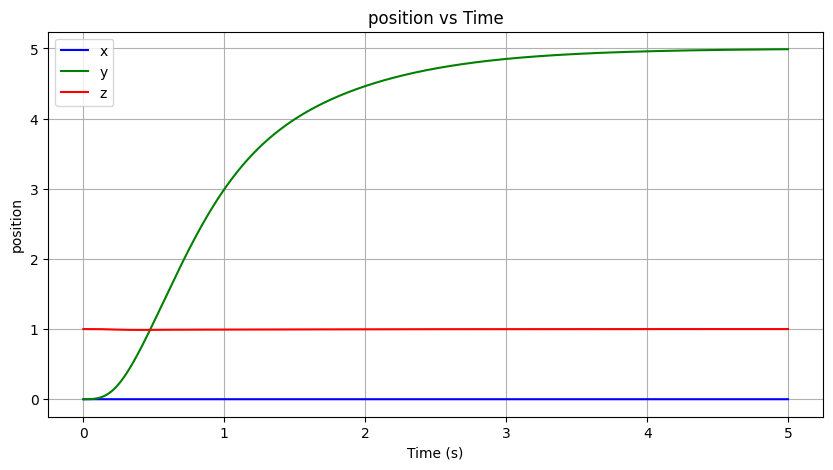

In [8]:
# Generate time array based on fixed step interval
time_log = np.arange(len(x_log)) * dt

# Plot theta and control input vs. time
plt.figure(figsize=(10, 5))
plt.plot(time_log, x_log, label="x", color="blue")
plt.plot(time_log, y_log, label="y", color="green")
plt.plot(time_log, z_log, label="z", color="red")
plt.xlabel("Time (s)")
plt.ylabel("position")
plt.title("position vs Time")
plt.legend()
plt.grid()
plt.show()


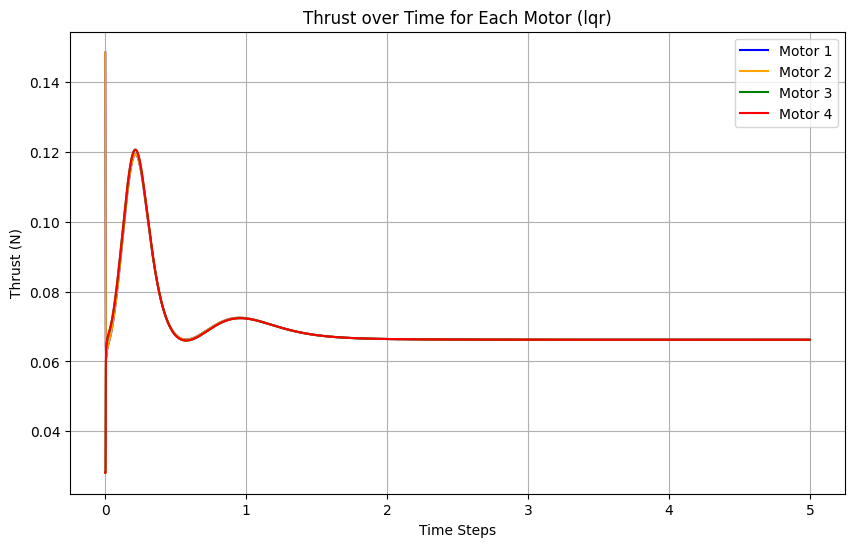

In [9]:
thrust_values = np.array(thrust_log)  # shape: (steps, 4)

time_log = np.arange(thrust_values.shape[0]) * dt

plt.figure(figsize=(10, 6))
plt.plot(time_log, thrust_values[:, 0], label="Motor 1", color="blue")
plt.plot(time_log, thrust_values[:, 1], label="Motor 2", color="orange")
plt.plot(time_log, thrust_values[:, 2], label="Motor 3", color="green")
plt.plot(time_log, thrust_values[:, 3], label="Motor 4", color="red")

plt.xlabel('Time Steps')
plt.ylabel('Thrust (N)')
plt.title('Thrust over Time for Each Motor (lqr)')
plt.legend()
plt.grid()
plt.show()

In [10]:
print(thrust_values.shape)

(2500, 4)


# ILQR

In [11]:
# Step 3: iLQR Implementation
input_ff = u_op + gain_lqr.dot(x_op)
gains_fb = - gain_lqr

# input_ff = np.tile(input_ff, (2500,1))
input_ff = np.tile(input_ff.reshape(4, 1), (1, 2500))
gains_fb = np.tile(gains_fb.reshape(1, nu, nx), (2500, 1, 1))

print(input_ff.shape)
print(gains_fb.shape)

(4, 2500)
(2500, 4, 12)


In [12]:
q_diag = [
    5, 3,
    5, 3, 
    5, 3,   # penalize linear velocities
    0.1, 0.1, 2,       # penalize orientations
    1, 1, 1        # penalize angular velocities
]
r_diag = [1, 1, 1, 1]
Q_ilqr = np.diag(q_diag)  # State cost
R_ilqr = np.diag(r_diag)  # Control cost

In [13]:
input_stack = 0

for iter in range(15):
    
    input_pre = input_stack

    # Forward
    obs, info = envs.reset_all(seed=SEED)
    for step in range(2500):
        
        state = obs_to_state(obs)
        # Calculate control input.
        assert not np.isnan(gains_fb[step]).any(), "gains are NaN"
        assert not np.isnan(input_ff[:, step]).any(), "FF terms are NaN"
        control_input = gains_fb[step].dot(state) + input_ff[:, step]
        
        # Clip the control input to the specified range
        control_input = np.clip(control_input, 0.028161688, 0.14834145) 
        
        # Convert to np.ndarray
        action = np.array([control_input], dtype=np.float32) 
        assert not np.isnan(action).any(), "NaN in action"
        # Save rollout data.
        if step == 0:
            # Initialize state and input stack.
            state_stack = state
            input_stack = action
        else:
            # Save state and input.
            # print("state_stack size:", state_stack.shape)
            # print("state size:", state.shape)
            # print("input_stack size:", input_stack.shape)
            # print("input size:", action.shape)
            state_stack = np.vstack((state_stack, state))
            input_stack = np.vstack((input_stack, action))

        # Step forward.
        obs, reward, terminated, truncated, _ = envs.step(action)
    envs.close()

    # Initialize backward pass.
    # state_k = cs.MX(state_stack[-1])
    state_k = state_stack[-1].reshape(-1, 1)
    input_k = u_op.reshape(-1, 1)

    # print("state_k type:", type(state_k))
    # print(state_stack.shape)
    # print(state_k.shape)
    # print("input_k type:", type(input_k))
    # print(input_k.shape)
    # print("x_op type:", type(x_op))
    # print("u_op type:", type(u_op))
    # print(type(Q))
    # print(type(R))
    # print(R)

    loss_k = symbolic_model.loss(
                        x=state_k,
                        u=input_k,
                        Xr=x_op,
                        Ur=u_op,
                        Q=Q_ilqr,
                        R=R_ilqr)
    s = loss_k['l'].toarray()
    Sv = loss_k['l_x'].toarray().transpose()
    Sm = loss_k['l_xx'].toarray().transpose()

    # Backward pass.
    for k in reversed(range(2500)):
        # Get current operating point.
        state_k = state_stack[k] #.reshape(-1, 1)
        input_k = input_stack[k] #.reshape(-1, 1)

        # Linearized dynamics about (x_k, u_k).
        df_k = symbolic_model.df_func(state_k, input_k)
        Ac_k, Bc_k = df_k[0].toarray(), df_k[1].toarray()
        Ad_k, Bd_k = discretize_linear_system(Ac_k, Bc_k, dt)

        # Jacobian and Hessian of the loss w.r.t. state and input.
        loss_k = symbolic_model.loss(x=state_k,
                                    u=input_k,
                                    Xr=x_op,
                                    Ur=u_op,
                                    Q=Q_ilqr,
                                    R=R_ilqr)

        # Quadratic approximation of cost.
        q = loss_k['l'].toarray()  # l
        Qv = loss_k['l_x'].toarray().transpose()  # dl/dx
        Qm = loss_k['l_xx'].toarray().transpose()  # ddl/dxdx
        Rv = loss_k['l_u'].toarray().transpose()  # dl/du
        Rm = loss_k['l_uu'].toarray().transpose()  # ddl/dudu
        Pm = loss_k['l_xu'].toarray().transpose()  # ddl/dudx

        # Control dependent terms of cost function.
        g = Rv + Bd_k.transpose().dot(Sv)
        G = Pm + Bd_k.transpose().dot(Sm.dot(Ad_k))
        H = Rm + Bd_k.transpose().dot(Sm.dot(Bd_k))
        
        # Trick to make sure H is well-conditioned for inversion
        # if not (np.isinf(np.sum(H)) or np.isnan(np.sum(H))):
        #     H = (H + H.transpose()) / 2
        #     H_eval, H_evec = np.linalg.eig(H)
        #     H_eval[H_eval < 0] = 0.0
        #     H_eval += 1e-6 #lamb

        # X = T^-1 * (L * + 1e-6) * T

        #     H_inv = np.dot(H_evec, np.dot(np.diag(1.0 / H_eval), H_evec.T))

        # Update controller gains.
        assert not np.isnan(H).any(), "H is NaN"
        H_inv = np.linalg.inv(H)
        assert not np.isnan(H_inv).any(), "H_inv is NaN"

        duff = -H_inv.dot(g)
        K = -H_inv.dot(G)

        # Update control input.
        input_ff_k = input_k + duff[:, 0] - K.dot(state_k)
        input_ff[:, k] = input_ff_k
        gains_fb[k] = K

        # Update s variables for time step k.
        Sm = Qm + Ad_k.transpose().dot(Sm.dot(Ad_k)) + \
            K.transpose().dot(H.dot(K)) + \
            K.transpose().dot(G) + G.transpose().dot(K)
        Sv = Qv + Ad_k.transpose().dot(Sv) + \
            K.transpose().dot(H.dot(duff)) + K.transpose().dot(g) + \
            G.transpose().dot(duff)
        s = q + s + 0.5 * duff.transpose().dot(H.dot(duff)) + \
            duff.transpose().dot(g)

AssertionError: H is NaN